In [1]:
from IF_functions import *
import os

In [2]:
pth = r'\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\5xFAD 12MO F3-1_IF slide1'
# pth = r'\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\WT 12MO F3-7_IF Slide1'

pth_tifs = os.path.join(pth, 'combined_ims')  # path of tif files of combined IF images (DAPI + other marker)
pth_coords = os.path.join(pth, 'cell_types_new') # path of xy coords of IF images

WSIs = sorted(glob(f'{pth_tifs}\*.tif'))

print(WSIs)

['\\\\10.99.68.178\\andreex\\data\\Alzherimers brain\\Stress Test Sample\\Initial_testing_data_3_4_24\\5xFAD 12MO F3-1_IF slide1\\combined_ims\\DAPI_Cy5.tif', '\\\\10.99.68.178\\andreex\\data\\Alzherimers brain\\Stress Test Sample\\Initial_testing_data_3_4_24\\5xFAD 12MO F3-1_IF slide1\\combined_ims\\DAPI_IBA.tif']


In [3]:
print(WSIs[0])
print(pth_coords)

\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\5xFAD 12MO F3-1_IF slide1\combined_ims\DAPI_Cy5.tif
\\10.99.68.178\andreex\data\Alzherimers brain\Stress Test Sample\Initial_testing_data_3_4_24\5xFAD 12MO F3-1_IF slide1\cell_types_new


In [4]:
Cy5_coords = load_var_from_mat(os.path.join(pth_coords, 'Cy5.mat'), "xy")

IBA_coords = load_var_from_mat(os.path.join(pth_coords, 'IBA.mat'), "xy")

In [5]:
adj_Cy5_coords = format_xy(Cy5_coords)
adj_IBA_coords = format_xy(IBA_coords)

In [6]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [7]:
WSIs[0]

'\\\\10.99.68.178\\andreex\\data\\Alzherimers brain\\Stress Test Sample\\Initial_testing_data_3_4_24\\5xFAD 12MO F3-1_IF slide1\\combined_ims\\DAPI_Cy5.tif'

In [8]:
# segment DAPI_Cy5 combined im
img = imread(WSIs[0])
img = img/255

labels_Cy5, polys_Cy5 = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 25/25 [00:45<00:00,  1.81s/it]


In [9]:
# segment DAPI_IBA combined im
img = imread(WSIs[1])
img = img/255

labels_IBA, polys_IBA = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 25/25 [00:53<00:00,  2.15s/it]


In [10]:
poly_Cy5_inds = get_indices_shapes(polys_Cy5, adj_Cy5_coords)
poly_IBA_inds = get_indices_shapes(polys_IBA, adj_IBA_coords)

In [11]:
# stardist got shapes for this ratio of positive cells
print(len(poly_Cy5_inds)/len(adj_Cy5_coords))

0.6025176754612864


In [14]:
Cy5_polys = polys_Cy5['coord'][poly_Cy5_inds, :]
IBA_polys = polys_IBA['coord'][poly_IBA_inds, :]

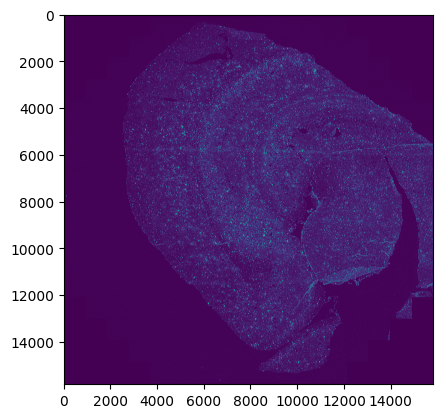

In [17]:
plt.imshow(img)

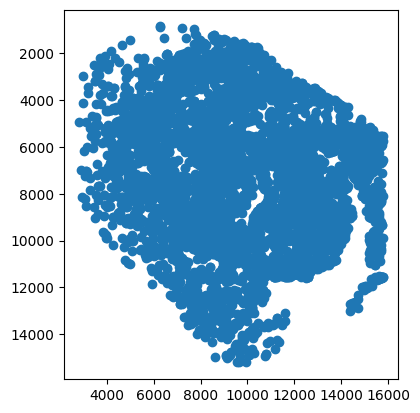

In [22]:
plt.scatter(adj_Cy5_coords[:,0], adj_Cy5_coords[:,1])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')

In [29]:
crop_x=9500
crop_y=12500

tile_size=1024*2

img = imread(WSIs[0])
img = img/255

cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

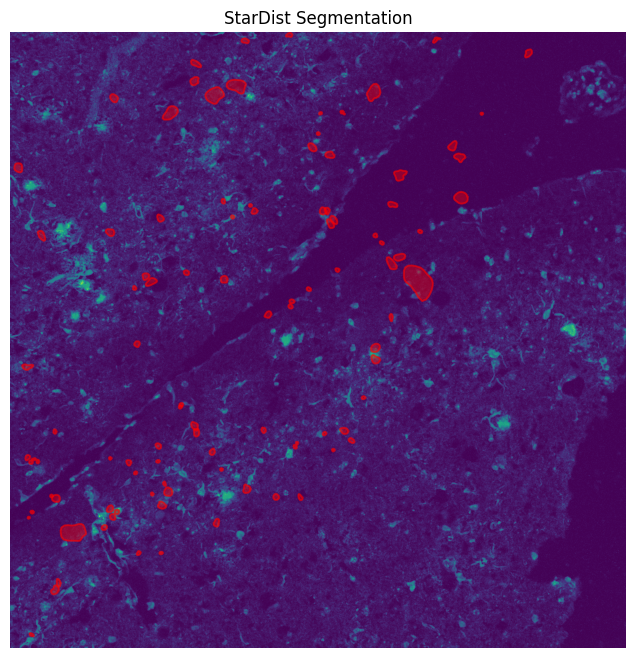

[295.01549687981606, 483.01118014752865, 2338.8583507984877, 103.75727002322674, 1501.363895341754, 437.1152352690697, 209.32778444886208, 49.57400870323181, 518.9195091724396, 576.9955373853445, 198.0451935827732, 2075.9291957467794, 1725.188257113099, 59.68567995727062, 499.26664793491364, 527.9382090866566, 251.74510145187378, 655.2147039026022, 208.20221084356308, 110.20491281151772, 116.54473482072353, 82.86446875333786, 457.5916209369898, 60.87800920009613, 70.57257568836212, 37.40115663409233, 82.49126479029655, 526.6001368463039, 94.82870221138, 623.1042509526014, 600.1903318911791, 502.6682161167264, 637.1407431289554, 422.49321426451206, 292.2411482036114, 7257.286719158292, 504.7073181346059, 570.6247771158814, 235.6977583616972, 142.68816923350096, 370.7092405706644, 422.73476841300726, 286.3363286405802, 275.7828519195318, 71.43186666071415, 80.08543814718723, 457.56164583563805, 184.79113917052746, 459.4391323104501, 172.56510987877846, 529.8321195170283, 75.6482645347714

In [30]:
cropped_shapes_for_plot, areas_in_crop = get_valid_shapes_for_crop(Cy5_polys, crop_x, crop_y, tile_size)
plot_new_shapes(cropped_img, cropped_shapes_for_plot)
print(areas_in_crop)

In [15]:
Cy5_output = get_output_df(Cy5_polys)
IBA_output = get_output_df(IBA_polys)

In [16]:
Cy5_output.head()

,0,1,2
0,2458.0,3790.0,313.111850
1,3334.0,3788.0,499.487467
2,3464.0,3188.0,357.335653
3,3768.0,3698.0,368.947909
4,2688.0,3660.0,584.172480


In [17]:
IBA_output.head()

,0,1,2
0,3454.0,3554.0,278.211335
1,2742.0,3093.0,789.760988
2,3680.0,3230.0,266.880275
3,3728.0,3264.0,286.364424
4,2698.0,3238.0,362.618838


In [20]:
from scipy.io import savemat

nm = 'Cy5_coords_with_area.mat'
outpth = os.path.join(pth_tifs, 'x_y_area_mats')
if not os.path.exists(outpth): os.makedirs(outpth)

outnm = os.path.join(outpth, nm)

savemat(outnm, {'x_y_area':Cy5_output})

In [21]:
nm = 'IBA_coords_with_area.mat'
outnm = os.path.join(outpth, nm)

savemat(outnm, {'x_y_area':IBA_output})